# Sentiment analysis

In [ ]:
!pip install "torch==2.0.1" datasets torchinfo stanza flair transformers tweetnlp pysentimiento 1> /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
torchaudio 2.3.0+cu121 requires torch==2.3.0, but you have torch 2.0.1 which is incompatible.
torchtext 0.18.0 requires torch>=2.3.0, but you have torch 2.0.1 which is incompatible.
torchvision 0.18.0+cu121 requires torch==2.3.0, but you have torch 2.0.1 which is incompatible.


In [10]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import time
import gc
from textblob import Blobber
from textblob.sentiments import PatternAnalyzer, NaiveBayesAnalyzer
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import torch
from torchinfo import summary
import stanza
from flair.nn import Classifier
from flair.data import Sentence
import datasets
import transformers
import tweetnlp
from pysentimiento import create_analyzer
import sys
import os
#from google.colab import drive

nltk.download('punkt', quiet=True)
nltk.download('movie_reviews', quiet=True)
nltk.download('vader_lexicon', quiet=True)
datasets.logging.disable_progress_bar()
transformers.logging.disable_progress_bar()
sys.stderr = open(os.devnull, 'w')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/korin.hoxha/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [33]:
INPUT_PATH = '/Users/korin.hoxha/Library/CloudStorage/OneDrive-RTLGroup/Korin Hoxha - Private/Personale/HU/SoSe 24/DEDA/content'  # Update this path as needed
OUTPUT_PATH = '/Users/korin.hoxha/Library/CloudStorage/OneDrive-RTLGroup/Korin Hoxha - Private/Personale/HU/SoSe 24/DEDA/model_output'
RAW_PATH = f'{OUTPUT_PATH}/raw'
FIGURE_PATH = 'figures'
DATASETS = ['reddit', 'youtube']
CATEGORIES = ['neg', 'pos']
BATCH_SIZE = 8
FONT_SIZE = 15
SENTENCES = ['This is a great test sentence with 10 tokens. ' * 10] * 10000
# EXAMPLES = [
#     'The movie was great',
#     'The movie was really great',
#     'The movie was not great',
#     'The movie was really not great',
#     'The movie was not that great',
#     'The movie could have been better'
# ]

In [22]:
def timed(func, *args, **kwargs):
    start = time.time()
    out = func(*args, **kwargs)
    return out, time.time() - start

def reduce_probabilities(a_prob):
    range_min = -1
    range_max = 1
    n_classes = len(a_prob)
    step = (range_max - range_min) / (n_classes - 1)
    a_reduced = 0
    for i in range(n_classes):
        a_reduced += (range_min + i * step) * a_prob[i]

    return a_reduced

def map_labels(a_prob):
    n_classes = len(a_prob)
    if n_classes == 2:
        class_to_label = {0: 'NEGATIVE', 1: 'POSITIVE'}
    elif n_classes == 3:
        class_to_label = {0: 'NEGATIVE', 1: 'NEUTRAL', 2: 'POSITIVE'}
    elif n_classes == 5:
        class_to_label = {0: 'NEGATIVE', 1: 'NEGATIVE', 2: 'NEUTRAL',
                          3: 'POSITIVE', 4: 'POSITIVE'}

    class_idx = np.argmax(a_prob)
    label = class_to_label[class_idx]
    return label

In [15]:
import os
print(os.getcwd())
os.chdir(os.getcwd())

/Users/korin.hoxha/Library/CloudStorage/OneDrive-RTLGroup/Korin Hoxha - Private/Personale/HU/SoSe 24/DEDA


# Datasets

In [4]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Define INPUT_PATH and DATASETS
INPUT_PATH = '/Users/korin.hoxha/Library/CloudStorage/OneDrive-RTLGroup/Korin Hoxha - Private/Personale/HU/SoSe 24/DEDA/content'  # Update this path as needed
DATASETS = ['reddit', 'youtube']

def save_split(dataset):
    input_folder = os.path.join(INPUT_PATH)
    # Assuming the filenames for train and test sets are consistent, like 'neutrogena_reddit_output_train.csv' and 'neutrogena_reddit_output_test.csv'
    train_file = os.path.join(input_folder, f'neutrogena_{dataset}_output_train.csv')
    test_file = os.path.join(input_folder, f'neutrogena_{dataset}_output_test.csv')

    if os.path.exists(train_file) and os.path.exists(test_file):
        train_df = pd.read_csv(train_file)
        test_df = pd.read_csv(test_file)
    else:
        # If train and test files don't exist, read the main CSV file and split it into train and test sets
        main_file = os.path.join(input_folder, f'neutrogena_{dataset}_output1.csv')
        if os.path.exists(main_file):
            main_df = pd.read_csv(main_file)
            train_df, test_df = train_test_split(main_df, test_size=0.2, random_state=42)  # Adjust test_size as needed
        else:
            print(f"File {main_file} not found.")
            return

    # Save the train and test sets
    train_df.to_csv(os.path.join(input_folder, f'neutrogena_{dataset}_output_train.csv'), index=False)
    test_df.to_csv(os.path.join(input_folder, f'neutrogena_{dataset}_output_test.csv'), index=False)

for dataset in DATASETS:
    save_split(dataset)


In [15]:
df = pd.read_csv(INPUT_PATH+'/neutrogena_reddit_output_train.csv')
df1 = pd.read_csv(INPUT_PATH+'/neutrogena_youtube_output_train.csv')
df.head()
df1.head()

,Unnamed: 0,date,text,source,videoID,videoURL,language
0,723,2022-09-09,Hello ma’am I just got my neutrogena micro pol...,youtube,BlHhGeWoCFk,https://www.youtube.com/watch?v=BlHhGeWoCFk,en
1,192,2020-07-16,The neutrogena hydro boost “extra dry” is frag...,youtube,nRX9S6yLLaU,https://www.youtube.com/watch?v=nRX9S6yLLaU,en
2,948,2021-05-14,I was glad to see this review since I recently...,youtube,f61NqK3EoUc,https://www.youtube.com/watch?v=f61NqK3EoUc,en
3,568,2021-02-04,what do you think about the neutrogena water b...,youtube,Mw22-BSE1Og,https://www.youtube.com/watch?v=Mw22-BSE1Og,en
4,451,2020-02-04,I love the grapefruit wash from neutrogena. It...,youtube,nRX9S6yLLaU,https://www.youtube.com/watch?v=nRX9S6yLLaU,en


# Sentiment calculation

## TextBlob (Pattern, Naive Bayes)

In [5]:
from textblob import TextBlob
from textblob.sentiments import PatternAnalyzer, NaiveBayesAnalyzer

In [18]:
from textblob import TextBlob
from textblob.sentiments import PatternAnalyzer, NaiveBayesAnalyzer
import pandas as pd
import os

def load_textblob(model_name):
    if model_name == 'pattern':
        return PatternAnalyzer()
    elif model_name == 'naivebayes':
        return NaiveBayesAnalyzer()

def textblob_output(pipe, texts):
    output = [TextBlob(x, analyzer=pipe).sentiment._asdict() for x in texts]
    return output

def textblob_polarities(output, model_name):
    if model_name == 'pattern':
        polarities = [x['polarity'] for x in output]
    elif model_name == 'naivebayes':
        scores = [[x['p_neg'], x['p_pos']] for x in output]
        polarities = [reduce_probabilities(score) for score in scores]

    return polarities

def textblob_demo(model_name, digits):
    pipe = load_textblob(model_name)
    train_texts = read_train_texts()  # Function to read train texts from CSV files
    if train_texts:
        output = textblob_output(pipe, train_texts)
        polarities = textblob_polarities(output, model_name)
        for text, polarity in zip(train_texts, polarities):
            if polarity is not None:  # Check if polarity is not None before formatting
                print(f'{text:<35} {polarity:.{digits}f}')  # Adjusted to format the polarity properly
            else:
                print(f'{text:<35} Polarity not available')  # Print a message if polarity is None
        print('')
    else:
        print("No train texts found.")

def read_train_texts():
    train_texts = []
    # Assuming train CSV files are stored in a folder named 'train_sets'
    train_folder = '/Users/korin.hoxha/Library/CloudStorage/OneDrive-RTLGroup/Korin Hoxha - Private/Personale/HU/SoSe 24/DEDA/content'  # Update with the actual path
    for file in os.listdir(train_folder):
        if 'train' in file and file.endswith('.csv'):
            df = pd.read_csv(os.path.join(train_folder, file))
            train_texts.extend(df['text'])  # Replace 'text_column_name' with the actual column name containing texts
    return train_texts

def reduce_probabilities(score):
    # Function to reduce Naive Bayes probabilities to polarity
    # Implement as per your requirements
    pass

textblob_demo('pattern', 2)
textblob_demo('naivebayes', 5)


Hello ma’am I just got my neutrogena micro polish todayy and was searching on how to use this product and found your review! What a timing.. I am subscribed to your channel but its been long time you come up on my feed 🫣 anyway I’m so happy to ask you my question 😀 so how do I include this in my skincare? I usually follow a simple ctm ritual.. do I skip my cleanser once a week and use micro polish scrub instead? Pls reply 0.12
The neutrogena hydro boost “extra dry” is fragrance free! 0.14
I was glad to see this review since I recently tried both neutrogena and Olay.

I have ended up keeping the Olay Regenerist 24 as my night cream and three times a week I use the Olay retinol serum underneath the cream.  The other 4 nights of the week I use The Ordinary Niacinamide serum to help calm and heal. 0.09
what do you think about the neutrogena water boost water gel cleanser? 0.00
I love the grapefruit wash from neutrogena. It's like the only thing that works for me and I've been using it for 

In [23]:
!python3 -m textblob.download_corpora

In [24]:
import nltk
import numpy as np

for category in CATEGORIES:
    word_list = nltk.corpus.movie_reviews.words(categories=category)
    not_count = np.sum([1 if word == 'not' else 0 for word in word_list])
    print(f'{category}: {not_count}')

neg: 2651
pos: 2926


In [23]:
import numpy as np
import time  

def textblob_time(model_name, n):
    pipe = load_textblob(model_name)
    t_list = []
    for i in range(n):
        _, t = timed(textblob_output, pipe, SENTENCES)
        t_list.append(t)

    t_average = np.round(np.mean(t_list), 1)
    t_rounds = np.array2string(np.round(t_list, 1), separator=', ')
    print(f'{model_name}: {t_average} s (average of {n} rounds), {t_rounds} s')

textblob_time('pattern', 3)
textblob_time('naivebayes', 3)


pattern: 3.1 s (average of 3 rounds), [3.2, 3.1, 3.1] s
naivebayes: 6.9 s (average of 3 rounds), [8.2, 5.8, 6.6] s


In [37]:
import json
def textblob_raw():
    for model_name in ['pattern', 'naivebayes']:
        pipe = load_textblob(model_name)
        for dataset in DATASETS:
            #for category in CATEGORIES:
                df_text = pd.read_csv(f'{INPUT_PATH}/neutrogena_{dataset}_output_train.csv')
                texts = df_text['text'].to_list()
                output, t = timed(textblob_output, pipe, texts)
                output_json = [json.dumps(x) for x in output]
                df_raw = pd.DataFrame({f'{model_name}_output': output_json})
                df_raw.to_csv(f'{RAW_PATH}/textblob_{model_name}_neutrogena_{dataset}.txt', index=False)
                print(f'{model_name}, {dataset}: {np.round(t, 1)} s')

        print('')

textblob_raw()

# CPU: pattern -> 11-14 s, naivebayes -> 20-33 s

pattern, reddit: 0.0 s
pattern, youtube: 0.1 s

naivebayes, reddit: 2.6 s
naivebayes, youtube: 0.2 s



In [39]:
def textblob_processed():
    for dataset in DATASETS:
        for category in CATEGORIES:
            df_processed = pd.DataFrame()
            for model_name in ['pattern', 'naivebayes']:
                df_raw = pd.read_csv(f'{RAW_PATH}/textblob_{model_name}_neutrogena_{dataset}.txt')
                output = df_raw[f'{model_name}_output'].apply(lambda x: json.loads(x)).to_list()
                polarities = textblob_polarities(output, model_name)
                df_processed[f'textblob_{model_name}_polarity'] = polarities

            df_processed.to_csv(f'{OUTPUT_PATH}/textblob_{dataset}.txt', index=False)

textblob_processed()

## NLTK VADER

In [29]:
def load_vader():
    pipe = SentimentIntensityAnalyzer()
    return pipe

In [30]:
import nltk
nltk.download('vader_lexicon')

True

In [32]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def load_vader():
    pipe = SentimentIntensityAnalyzer()
    return pipe

def vader_output(pipe, texts):
    output = [pipe.polarity_scores(x) for x in texts]
    return output

def vader_polarities(output):
    polarities = [x['compound'] for x in output]
    return polarities

def vader_demo(digits):
    pipe = load_vader()
    output = vader_output(pipe, EXAMPLES)
    polarities = vader_polarities(output)
    for text, polarity in zip(EXAMPLES, polarities):
        print(f'{text:<35} {polarity:.{digits}}')

vader_demo(2)


The movie was great                 0.62
The movie was really great          0.66
The movie was not great             -0.51
The movie was really not great      -0.55
The movie was not that great        -0.51
The movie could have been better    0.44


In [33]:
def vader_time(n):
    pipe = load_vader()
    t_list = []
    for i in range(n):
        _, t = timed(vader_output, pipe, SENTENCES)
        t_list.append(t)

    t_average = np.round(np.mean(t_list), 1)
    t_rounds = np.array2string(np.round(t_list, 1), separator=', ')
    print(f'vader: {t_average} s (average of {n} rounds), {t_rounds} s')

vader_time(3)

# CPU: vader -> 5 s

vader: 1.7 s (average of 3 rounds), [1.7, 1.7, 1.7] s


In [34]:
def vader_raw():
    pipe = load_vader()
    for dataset in DATASETS:
        for category in CATEGORIES:
            df_text = pd.read_csv(f'{INPUT_PATH}/{dataset}_{category}.txt')
            texts = df_text['text'].to_list()
            output, t = timed(vader_output, pipe, texts)
            output_json = [json.dumps(x) for x in output]
            df_raw = pd.DataFrame({'vader_output': output_json})
            df_raw.to_csv(f'{RAW_PATH}/vader_raw_{dataset}_{category}.txt', index=False)
            print(f'vader, {dataset}_{category}: {np.round(t, 1)} s')

vader_raw()

# CPU: vader -> 16-21 s

vader, yelp_neg: 7.2 s
vader, yelp_pos: 5.7 s
vader, tweet_neg: 0.5 s
vader, tweet_pos: 0.2 s
vader, finance_neg: 0.1 s
vader, finance_pos: 0.1 s


In [35]:
def vader_processed():
    for dataset in DATASETS:
        for category in CATEGORIES:
            df_raw = pd.read_csv(f'{RAW_PATH}/vader_raw_{dataset}_{category}.txt')
            output = df_raw['vader_output'].apply(lambda x: json.loads(x)).to_list()
            polarities = vader_polarities(output)
            df_processed = pd.DataFrame({'vader_polarity': polarities})
            df_processed.to_csv(f'{OUTPUT_PATH}/vader_{dataset}_{category}.txt', index=False)

vader_processed()

## VADER (R)

In [ ]:
%%R

vaderr_output = function(texts) {
    output = select(vader_df(texts), -c('text'))
    return(output)
}

vaderr_polarities = function(output) {
    polarities = output$compound
    return(polarities)
}

vaderr_demo = function(digits) {
    for (text in EXAMPLES) {
        output = vaderr_output(text)
        polarity = vaderr_polarities(output)
        print(glue('{format(text, width=35)} {round(polarity, digits)}'))
    }
}

vaderr_demo(2)

In [ ]:
%%R

vaderr_time = function(n) {
    t_list = c()
    for (i in 1:n) {
        start = Sys.time()
        vaderr_output(SENTENCES)
        end = Sys.time()
        t = as.numeric(difftime(end, start, units='secs'))
        t_list = append(t_list, t)
    }

    t_average = round(mean(t_list), 1)
    t_list = paste(round(t_list, 1), collapse=', ')
    print(glue('vaderr: {t_average} s (average of {n} rounds), [{t_list}] s'))
}

vaderr_time(1)

# CPU: vaderr -> 1900 s

## Sentimentr (R)

In [ ]:
%%R

sentimentr_output = function(texts) {
    sentences = get_sentences(texts)
    output = sentiment_by(sentences)
    return(output)
}

sentimentr_polarities = function(output) {
    polarities = pmax(pmin(output$ave_sentiment, 1), -1)
    return(polarities)
}

sentimentr_demo = function(digits) {
    for (text in EXAMPLES) {
        output = sentimentr_output(text)
        polarity = sentimentr_polarities(output)
        print(glue('{format(text, width=35)} {round(polarity, digits)}'))
    }
}

sentimentr_demo(2)

In [ ]:
%%R

sentimentr_time = function(n) {
    t_list = c()
    for (i in 1:n) {
        start = Sys.time()
        sentimentr_output(SENTENCES)
        end = Sys.time()
        t = as.numeric(difftime(end, start, units='secs'))
        t_list = append(t_list, t)
    }

    t_average = round(mean(t_list), 1)
    t_list = paste(round(t_list, 1), collapse=', ')
    print(glue('sentimentr: {t_average} s (average of {n} rounds), [{t_list}] s'))
}

sentimentr_time(3)

# CPU: sentimentr -> 45 s

In [ ]:
%%R

sentimentr_raw = function() {
    for (dataset in DATASETS) {
        for (category in CATEGORIES) {
            tbl_text = read_delim(glue('{INPUT_PATH}/{dataset}_{category}.txt'),
                                  delim=',', show_col_types = FALSE)
            texts = tbl_text$text
            start = Sys.time()
            output = sentimentr_output(texts)
            end = Sys.time()
            t = as.numeric(difftime(end, start, units='secs'))
            tbl_raw = as_tibble(output)
            write_csv(tbl_raw, glue('{RAW_PATH}/sentimentr_raw_{dataset}_{category}.txt'))
            print(glue('sentimentr, {dataset}_{category}: {round(t, 1)} s'))
        }
    }
}

sentimentr_raw()

# CPU: sentimentr -> 60-85 s

In [ ]:
%%R

sentimentr_processed = function() {
    for (dataset in DATASETS) {
        for (category in CATEGORIES) {
            tbl_raw = read_delim(glue('{RAW_PATH}/sentimentr_raw_{dataset}_{category}.txt'),
                                 show_col_types = FALSE)
            polarities = sentimentr_polarities(tbl_raw)
            tbl_processed = tibble(sentimentr_polarity=polarities)
            write_csv(tbl_processed, glue('{OUTPUT_PATH}/sentimentr_{dataset}_{category}.txt'))
        }
    }
}

sentimentr_processed()

## Stanza

In [36]:
!pip3 install torchinfo


Defaulting to user installation because normal site-packages is not writeable


In [37]:
def load_stanza():
    pipe = stanza.Pipeline(lang='en', processors='tokenize,sentiment',
                           tokenize_no_ssplit=True, verbose=False)
    return pipe

In [38]:
import gc
import torch
import stanza  # Add this line to import the stanza module
from torchinfo import summary  # Import the summary function


def stanza_summary():
    pipe = load_stanza()
    model = pipe.processors['sentiment']._model
    print(model)
    print(summary(model))
    del pipe
    gc.collect()
    torch.cuda.empty_cache()

stanza_summary()


CNNClassifier(
  (embedding): Embedding(250000, 100)
  (forward_charlm): CharacterLanguageModel(
    (char_emb): Embedding(948, 100)
    (charlstm): PackedLSTM(
      (lstm): LSTM(100, 1024, batch_first=True)
    )
    (decoder): Linear(in_features=1024, out_features=948, bias=True)
    (dropout): Dropout(p=0.05, inplace=False)
    (char_dropout): SequenceUnitDropout(p=1e-05, replacement_id=1)
  )
  (backward_charlm): CharacterLanguageModel(
    (char_emb): Embedding(948, 100)
    (charlstm): PackedLSTM(
      (lstm): LSTM(100, 1024, batch_first=True)
    )
    (decoder): Linear(in_features=1024, out_features=948, bias=True)
    (dropout): Dropout(p=0.05, inplace=False)
    (char_dropout): SequenceUnitDropout(p=1e-05, replacement_id=1)
  )
  (extra_embedding): Embedding(31014, 100, padding_idx=0)
  (bilstm): LSTM(2148, 300, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (conv_layers): ModuleList(
    (0): Conv2d(1, 1000, kernel_size=(3, 600), stride=(1, 1))
    (1):

In [ ]:
def stanza_output(pipe, texts):
    result = pipe.stream(texts, batch_size=BATCH_SIZE)
    output = [y.sentiment for x in result for y in x.sentences]
    return output

def stanza_polarities(output):
    label_to_polarity = {0: -1.0, 1: 0.0, 2: 1.0}
    polarities = [label_to_polarity[x] for x in output]
    return polarities

def stanza_demo(digits):
    pipe = load_stanza()
    output = stanza_output(pipe, EXAMPLES)
    polarities = stanza_polarities(output)
    for text, polarity in zip(EXAMPLES, polarities):
        print(f'{text:<35} {polarity:.{digits}}')

    print('')
    del pipe
    gc.collect()
    torch.cuda.empty_cache()

stanza_demo(2)

The movie was great                 1.0
The movie was really great          1.0
The movie was not great             -1.0
The movie was really not great      -1.0
The movie was not that great        -1.0
The movie could have been better    -1.0



In [ ]:
def stanza_time(n):
    pipe = load_stanza()
    t_list = []
    for i in range(n):
        _, t = timed(stanza_output, pipe, SENTENCES)
        t_list.append(t)

    t_average = np.round(np.mean(t_list), 1)
    t_rounds = np.array2string(np.round(t_list, 1), separator=', ')
    print(f'stanza: {t_average} s (average of {n} rounds), {t_rounds} s')
    del pipe
    gc.collect()
    torch.cuda.empty_cache()

stanza_time(3)

# GPU: stanza -> 230 s

KeyboardInterrupt: 

In [ ]:
def stanza_raw():
    pipe = load_stanza()
    for dataset in DATASETS:
        for category in CATEGORIES:
            df_text = pd.read_csv(f'{INPUT_PATH}/{dataset}_{category}.txt')
            texts = df_text['text'].to_list()
            output, t = timed(stanza_output, pipe, texts)
            df_raw = pd.DataFrame({'stanza_output': output})
            df_raw.to_csv(f'{RAW_PATH}/stanza_raw_{dataset}_{category}.txt', index=False)
            print(f'stanza, {dataset}_{category}: {np.round(t, 1)} s')

    del pipe
    gc.collect()
    torch.cuda.empty_cache()

stanza_raw()

# GPU: stanza -> 505-705 s

KeyboardInterrupt: 

In [ ]:
def stanza_processed():
    for dataset in DATASETS:
        for category in CATEGORIES:
            df_raw = pd.read_csv(f'{RAW_PATH}/stanza_raw_{dataset}_{category}.txt')
            output = df_raw['stanza_output'].to_list()
            polarities = stanza_polarities(output)
            df_processed = pd.DataFrame({'stanza_polarity': polarities})
            df_processed.to_csv(f'{OUTPUT_PATH}/stanza_{dataset}_{category}.txt', index=False)

stanza_processed()

## Flair (RNN, distilBERT)

In [39]:
def load_flair(model_name):
    if model_name == 'rnn':
        pipe = Classifier.load('sentiment-fast')
    elif model_name == 'distilbert':
        pipe = Classifier.load('sentiment')

    return pipe

In [40]:
from flair.nn import Classifier

def flair_summary(model_name):
    model = load_flair(model_name)
    print(model)
    print(summary(model))
    print('')
    del model
    gc.collect()
    torch.cuda.empty_cache()

flair_summary('rnn')
flair_summary('distilbert')

2024-06-08 19:49:06,827 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-fasttext-rnn/sentiment-en-mix-ft-rnn_v8.pt not found in cache, downloading to /var/folders/c3/q7mlsbm15wlb3xbd6kckhhx80000gn/T/tmpcn9figwv
2024-06-08 19:52:01,095 copying /var/folders/c3/q7mlsbm15wlb3xbd6kckhhx80000gn/T/tmpcn9figwv to cache at /Users/korin.hoxha/.flair/models/sentiment-en-mix-ft-rnn_v8.pt
2024-06-08 19:52:02,686 removing temp file /var/folders/c3/q7mlsbm15wlb3xbd6kckhhx80000gn/T/tmpcn9figwv
TextClassifier(
  (embeddings): DocumentRNNEmbeddings(
    (embeddings): StackedEmbeddings(
      (list_embedding_0): WordEmbeddings('en-crawl')
    )
    (word_reprojection_map): Linear(in_features=300, out_features=300, bias=True)
    (rnn): LSTM(300, 256, batch_first=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (locked_dropout): LockedDropout(p=0.0)
  (word_dropout): Wo

In [41]:
from flair.data import Sentence

def flair_output(pipe, texts):
    sentences = [Sentence(text) for text in texts]
    pipe.predict(sentences, mini_batch_size=BATCH_SIZE)
    output = []
    for sentence in sentences:
        result = sentence.labels[0]
        label = result.value
        score = result.score
        output.append({label: score})

    return output

def flair_polarities(output):
    scores = []
    for x in output:
        if 'NEGATIVE' in x.keys():
            score = [x['NEGATIVE'], (1 - x['NEGATIVE'])]
        elif 'POSITIVE' in x.keys():
            score = [(1 - x['POSITIVE']), x['POSITIVE']]
        scores.append(score)

    polarities = [reduce_probabilities(score) for score in scores]
    labels = [map_labels(score) for score in scores]
    return polarities, labels

def flair_demo(model_name, digits):
    pipe = load_flair(model_name)
    output = flair_output(pipe, EXAMPLES)
    polarities, _ = flair_polarities(output)
    for text, polarity in zip(EXAMPLES, polarities):
        print(f'{text:<35} {polarity:.{digits}}')

    print('')
    del pipe
    gc.collect()
    torch.cuda.empty_cache()

flair_demo('rnn', 5)
flair_demo('distilbert', 5)

The movie was great                 0.84534
The movie was really great          0.7819
The movie was not great             -0.99959
The movie was really not great      -0.99843
The movie was not that great        -0.9996
The movie could have been better    -0.94291

The movie was great                 0.90476
The movie was really great          0.9369
The movie was not great             -0.99895
The movie was really not great      -0.99819
The movie was not that great        -0.99941
The movie could have been better    -0.99972



In [42]:
def flair_time(model_name, n):
    pipe = load_flair(model_name)
    t_list = []
    for i in range(n):
        _, t = timed(flair_output, pipe, SENTENCES)
        t_list.append(t)

    t_average = np.round(np.mean(t_list), 1)
    t_rounds = np.array2string(np.round(t_list, 1), separator=', ')
    print(f'{model_name}: {t_average} s (average of {n} rounds), {t_rounds} s')
    del pipe
    gc.collect()
    torch.cuda.empty_cache()

flair_time('rnn', 3)
flair_time('distilbert', 3)

# GPU: rnn -> 40 s, distilbert -> 60 s

rnn: 23.9 s (average of 3 rounds), [22.2, 26.5, 23. ] s
distilbert: 204.9 s (average of 3 rounds), [209.5, 203.4, 201.8] s


In [43]:
def flair_raw():
    for model_name in ['rnn', 'distilbert']:
        pipe = load_flair(model_name)
        for dataset in DATASETS:
            for category in CATEGORIES:
                df_text = pd.read_csv(f'{INPUT_PATH}/{dataset}_{category}.txt')
                texts = df_text['text'].to_list()
                output, t = timed(flair_output, pipe, texts)
                output_json = [json.dumps(x) for x in output]
                df_raw = pd.DataFrame({f'{model_name}_output': output_json})
                df_raw.to_csv(f'{RAW_PATH}/flair_{model_name}_{dataset}_{category}.txt', index=False)
                print(f'{model_name}, {dataset}_{category}: {np.round(t, 1)} s')

        print('')
        del pipe
        gc.collect()
        torch.cuda.empty_cache()

flair_raw()

# GPU: rnn -> 45-65 s, distilbert -> 85-105 s

rnn, yelp_neg: 39.7 s
rnn, yelp_pos: 33.4 s
rnn, tweet_neg: 3.5 s
rnn, tweet_pos: 1.2 s
rnn, finance_neg: 0.3 s
rnn, finance_pos: 1.7 s

distilbert, yelp_neg: 381.9 s
distilbert, yelp_pos: 293.4 s
distilbert, tweet_neg: 30.1 s
distilbert, tweet_pos: 16.5 s
distilbert, finance_neg: 4.6 s
distilbert, finance_pos: 10.2 s



In [44]:
def flair_processed():
    for dataset in DATASETS:
        for category in CATEGORIES:
            df_processed = pd.DataFrame()
            for model_name in ['rnn', 'distilbert']:
                df_raw = pd.read_csv(f'{RAW_PATH}/flair_{model_name}_{dataset}_{category}.txt')
                output = df_raw[f'{model_name}_output'].apply(lambda x: json.loads(x)).to_list()
                polarities, labels = flair_polarities(output)
                df_processed[f'flair_{model_name}_polarity'] = polarities
                df_processed[f'flair_{model_name}_label'] = labels

            df_processed.to_csv(f'{OUTPUT_PATH}/flair_{dataset}_{category}.txt', index=False)

flair_processed()

## HuggingFace (distilBERT, BERT, GPT-2)

In [ ]:
def load_huggingface(model_name):
    if model_name == 'distilbert':
        model = 'distilbert-base-uncased-finetuned-sst-2-english'
    elif model_name == 'bert':
        model = 'nlptown/bert-base-multilingual-uncased-sentiment'
    elif model_name == 'gpt2':
        model = 'michelecafagna26/gpt2-medium-finetuned-sst2-sentiment'

    if torch.cuda.is_available():
        device = 0
    else:
        device = 'cpu'

    pipe = transformers.pipeline(task='text-classification', model=model, device=device,
                                 batch_size=BATCH_SIZE, truncation=True, top_k=None)
    return pipe

In [ ]:
def huggingface_summary(model_name):
    pipe = load_huggingface(model_name)
    model = pipe.model
    print(model)
    print(summary(model))
    print('')
    del pipe
    gc.collect()
    torch.cuda.empty_cache()

huggingface_summary('distilbert')
huggingface_summary('bert')
huggingface_summary('gpt2')

In [ ]:
def huggingface_output(pipe, texts):
    output = pipe(texts)
    return output

def huggingface_polarities(output):
    label_score_list = []
    for x in output:
        label_score = {}
        for y in x:
            label_score.update({y['label']: y['score']})
        label_score_sorted = sorted(label_score.items())
        label_score_list.append(label_score_sorted)

    scores = []
    for x in label_score_list:
        scores.append([y[1] for y in x])

    polarities = [reduce_probabilities(score) for score in scores]
    labels = [map_labels(score) for score in scores]
    return polarities, labels

def huggingface_demo(model_name, digits):
    pipe = load_huggingface(model_name)
    output = huggingface_output(pipe, EXAMPLES)
    polarities, _ = huggingface_polarities(output)
    for text, polarity in zip(EXAMPLES, polarities):
        print(f'{text:<35} {polarity:.{digits}}')

    print('')
    del pipe
    gc.collect()
    torch.cuda.empty_cache()

huggingface_demo('distilbert', 6)
huggingface_demo('bert', 5)
huggingface_demo('gpt2', 5)

In [ ]:
def huggingface_time(model_name, n):
    pipe = load_huggingface(model_name)
    t_list = []
    for i in range(n):
        _, t = timed(huggingface_output, pipe, SENTENCES)
        t_list.append(t)

    t_average = np.round(np.mean(t_list), 1)
    t_rounds = np.array2string(np.round(t_list, 1), separator=', ')
    print(f'{model_name}: {t_average} s (average of {n} rounds), {t_rounds} s')
    del pipe
    gc.collect()
    torch.cuda.empty_cache()

huggingface_time('distilbert', 3)
huggingface_time('bert', 3)
huggingface_time('gpt2', 3)

# GPU: distilbert -> 35 s, bert -> 70 s, gpt2 -> 280 s

In [ ]:
def huggingface_raw():
    for model_name in ['distilbert', 'bert', 'gpt2']:
        pipe = load_huggingface(model_name)
        for dataset in DATASETS:
            for category in CATEGORIES:
                df_text = pd.read_csv(f'{INPUT_PATH}/{dataset}_{category}.txt')
                texts = df_text['text'].to_list()
                output, t = timed(huggingface_output, pipe, texts)
                output_json = [json.dumps(x) for x in output]
                df_raw = pd.DataFrame({f'{model_name}_output': output_json})
                df_raw.to_csv(f'{RAW_PATH}/huggingface_{model_name}_{dataset}_{category}.txt', index=False)
                print(f'{model_name}, {dataset}_{category}: {np.round(t, 1)} s')

        print('')
        del pipe
        gc.collect()
        torch.cuda.empty_cache()

huggingface_raw()

# GPU: distilbert -> 110-135 s, bert -> 215-265 s, gpt2 -> 1090-1570 s

In [ ]:
def huggingface_processed():
    for dataset in DATASETS:
        for category in CATEGORIES:
            df_processed = pd.DataFrame()
            for model_name in ['distilbert', 'bert', 'gpt2']:
                df_raw = pd.read_csv(f'{RAW_PATH}/huggingface_{model_name}_{dataset}_{category}.txt')
                output = df_raw[f'{model_name}_output'].apply(lambda x: json.loads(x)).to_list()
                polarities, labels = huggingface_polarities(output)
                df_processed[f'huggingface_{model_name}_polarity'] = polarities
                df_processed[f'huggingface_{model_name}_label'] = labels

            df_processed.to_csv(f'{OUTPUT_PATH}/huggingface_{dataset}_{category}.txt', index=False)

huggingface_processed()

## TweetNLP (roBERTa, roBERTa XLM)

In [ ]:
def load_tweetnlp(model_name):
    if model_name == 'roberta':
        pipe = tweetnlp.load_model('sentiment')
    elif model_name == 'robertaold':
        pipe = tweetnlp.load_model('sentiment', model_name='cardiffnlp/twitter-roberta-base-sentiment')
    elif model_name == 'robertaxlm':
        pipe = tweetnlp.load_model('sentiment', multilingual=True)

    return pipe

In [ ]:
def tweetnlp_summary(model_name):
    pipe = load_tweetnlp(model_name)
    model = pipe.model
    print(model)
    print(summary(model))
    print('')
    del pipe
    gc.collect()
    torch.cuda.empty_cache()

tweetnlp_summary('roberta')
tweetnlp_summary('robertaold')
tweetnlp_summary('robertaxlm')

In [ ]:
def tweetnlp_output(pipe, texts):
    output = pipe.sentiment(texts, return_probability=True, batch_size=BATCH_SIZE)
    return output

def tweetnlp_polarities(output):
    scores = [list(x['probability'].values()) for x in output]
    polarities = [reduce_probabilities(score) for score in scores]
    labels = [map_labels(score) for score in scores]
    return polarities, labels

def tweetnlp_demo(model_name, digits):
    pipe = load_tweetnlp(model_name)
    output = tweetnlp_output(pipe, EXAMPLES)
    polarities, _ = tweetnlp_polarities(output)
    for text, polarity in zip(EXAMPLES, polarities):
        print(f'{text:<35} {polarity:.{digits}}')

    print('')
    del pipe
    gc.collect()
    torch.cuda.empty_cache()

tweetnlp_demo('roberta', 5)
tweetnlp_demo('robertaold', 5)
tweetnlp_demo('robertaxlm', 5)

In [ ]:
def tweetnlp_time(model_name, n):
    pipe = load_tweetnlp(model_name)
    t_list = []
    for i in range(n):
        _, t = timed(tweetnlp_output, pipe, SENTENCES)
        t_list.append(t)

    t_average = np.round(np.mean(t_list), 1)
    t_rounds = np.array2string(np.round(t_list, 1), separator=', ')
    print(f'{model_name}: {t_average} s (average of {n} rounds), {t_rounds} s')
    del pipe
    gc.collect()
    torch.cuda.empty_cache()
    time.sleep(30)

tweetnlp_time('roberta', 3)  # 105 s
tweetnlp_time('robertaold', 3)  # 105 s
tweetnlp_time('robertaxlm', 3)  # 110 s

In [ ]:
def tweetnlp_raw():
    for model_name in ['roberta', 'robertaold', 'robertaxlm']:
        pipe = load_tweetnlp(model_name)
        for dataset in DATASETS:
            for category in CATEGORIES:
                df_text = pd.read_csv(f'{INPUT_PATH}/{dataset}_{category}.txt')
                texts = df_text['text'].to_list()
                output, t = timed(tweetnlp_output, pipe, texts)
                output_json = [json.dumps(x) for x in output]
                df_raw = pd.DataFrame({f'{model_name}_output': output_json})
                df_raw.to_csv(f'{RAW_PATH}/tweetnlp_{model_name}_{dataset}_{category}.txt', index=False)
                print(f'{model_name}, {dataset}_{category}: {np.round(t, 1)} s')

        print('')
        del pipe
        gc.collect()
        torch.cuda.empty_cache()

tweetnlp_raw()

# GPU: roberta -> 125-145 s, robertaold -> 125-145 s, robertaxlm -> 125-145 s

In [ ]:
def tweetnlp_processed():
    for dataset in DATASETS:
        for category in CATEGORIES:
            df_processed = pd.DataFrame()
            for model_name in ['roberta', 'robertaold', 'robertaxlm']:
                df_raw = pd.read_csv(f'{RAW_PATH}/tweetnlp_{model_name}_{dataset}_{category}.txt')
                output = df_raw[f'{model_name}_output'].apply(lambda x: json.loads(x)).to_list()
                polarities, labels = tweetnlp_polarities(output)
                df_processed[f'tweetnlp_{model_name}_polarity'] = polarities
                df_processed[f'tweetnlp_{model_name}_label'] = labels

            df_processed.to_csv(f'{OUTPUT_PATH}/tweetnlp_{dataset}_{category}.txt', index=False)

tweetnlp_processed()

## Pysentimiento (BERTweet)

In [ ]:
def load_pysentimiento():
    pipe = create_analyzer('sentiment', lang='en', batch_size=BATCH_SIZE)
    return pipe

In [ ]:
def pysentimiento_summary():
    pipe = load_pysentimiento()
    model = pipe.model
    print(model)
    print(summary(model))
    del pipe
    gc.collect()
    torch.cuda.empty_cache()

pysentimiento_summary()

In [ ]:
def pysentimiento_output(pipe, texts):
    output = [x.probas for x in pipe.predict(texts)]
    return output

def pysentimiento_polarities(output):
    output_sorted = [sorted(x.items()) for x in output]
    scores = []
    for x in output_sorted:
        scores.append([y[1] for y in x])

    polarities = [reduce_probabilities(score) for score in scores]
    labels = [map_labels(score) for score in scores]
    return polarities, labels

def pysentimiento_demo(digits):
    pipe = load_pysentimiento()
    output = pysentimiento_output(pipe, EXAMPLES)
    polarities, _ = pysentimiento_polarities(output)
    for text, polarity in zip(EXAMPLES, polarities):
        print(f'{text:<35} {polarity:.{digits}}')

    print('')
    del pipe
    gc.collect()
    torch.cuda.empty_cache()

pysentimiento_demo(5)

In [ ]:
def pysentimiento_time(n):
    pipe = load_pysentimiento()
    t_list = []
    for i in range(n):
        _, t = timed(pysentimiento_output, pipe, SENTENCES)
        t_list.append(t)

    t_average = np.round(np.mean(t_list), 1)
    t_rounds = np.array2string(np.round(t_list, 1), separator=', ')
    print(f'pysentimiento: {t_average} s (average of {n} rounds), {t_rounds} s')
    del pipe
    gc.collect()
    torch.cuda.empty_cache()

pysentimiento_time(3)

# GPU: pysentimiento -> 85 s

In [ ]:
def pysentimiento_raw():
    pipe = load_pysentimiento()
    for dataset in DATASETS:
        for category in CATEGORIES:
            df_text = pd.read_csv(f'{INPUT_PATH}/{dataset}_{category}.txt')
            texts = df_text['text'].to_list()
            output, t = timed(pysentimiento_output, pipe, texts)
            output_json = [json.dumps(x) for x in output]
            df_raw = pd.DataFrame({f'pysentimiento_output': output_json})
            df_raw.to_csv(f'{RAW_PATH}/pysentimiento_raw_{dataset}_{category}.txt', index=False)
            print(f'pysentimiento, {dataset}_{category}: {np.round(t, 1)} s')

    del pipe
    gc.collect()
    torch.cuda.empty_cache()

pysentimiento_raw()

# GPU: pysentimiento -> 90-95 s

In [ ]:
def pysentimiento_processed():
    for dataset in DATASETS:
        for category in CATEGORIES:
            df_processed = pd.DataFrame()
            df_raw = pd.read_csv(f'{RAW_PATH}/pysentimiento_raw_{dataset}_{category}.txt')
            output = df_raw[f'pysentimiento_output'].apply(lambda x: json.loads(x))
            polarities, labels = pysentimiento_polarities(output)
            df_processed[f'pysentimiento_polarity'] = polarities
            df_processed[f'pysentimiento_label'] = labels
            df_processed.to_csv(f'{OUTPUT_PATH}/pysentimiento_{dataset}_{category}.txt', index=False)

pysentimiento_processed()

# Sentiment classification

## Classification results

In [45]:
def combine_all():
    packages = ['textblob', 'vader',# 'sentimentr', 'stanza',
                'flair'#, 'huggingface', 'tweetnlp', 'pysentimiento'
                ]
    for dataset in DATASETS:
        for category in CATEGORIES:
            df_all = pd.DataFrame()
            for package in packages:
                df = pd.read_csv(f'{OUTPUT_PATH}/{package}_{dataset}_{category}.txt')
                df_all = pd.concat([df_all, df], axis=1)

            df_all.to_csv(f'{OUTPUT_PATH}/all_{dataset}_{category}.txt', index=False)

combine_all()

In [46]:
model_title = (
    ('textblob_pattern', 'TextBlob Pattern'),
    ('textblob_naivebayes', 'TextBlob Naive Bayes'),
    ('vader', 'VADER'),
    # ('sentimentr', 'Sentimentr'),
    # ('stanza', 'Stanza'),
    ('flair_rnn', 'Flair RNN'),
    ('flair_distilbert', 'Flair DistilBERT')
    # ('huggingface_distilbert', 'HuggingFace DistilBERT'),
    # ('huggingface_gpt2', 'HuggingFace GPT-2'),
    # ('huggingface_bert', 'HuggingFace BERT'),
    # ('tweetnlp_roberta', 'TweetNLP RoBERTa'),
    # ('tweetnlp_robertaold', 'TweetNLP RoBERTa old'),
    # ('tweetnlp_robertaxlm', 'TweetNLP RoBERTa XLM'),
    # ('pysentimiento', 'Pysentimiento BERTweet'),
)

In [47]:
def classification_polarity_pos_neg(model_name, dataset, threshold=None):
    df_pos = pd.read_csv(f'{OUTPUT_PATH}/all_{dataset}_pos.txt')
    df_neg = pd.read_csv(f'{OUTPUT_PATH}/all_{dataset}_neg.txt')
    if threshold != None:
        col = f'{model_name}_polarity'
        tp = np.double(df_pos.query(f'{col} > {threshold}').shape[0])
        fp = np.double(df_neg.query(f'{col} > {threshold}').shape[0])
        tn = np.double(df_neg.query(f'{col} < -{threshold}').shape[0])
        fn = np.double(df_pos.query(f'{col} < -{threshold}').shape[0])
    else:
        col = f'{model_name}_label'
        tp = np.double(df_pos.query(f'{col} == "POSITIVE"').shape[0])
        fp = np.double(df_neg.query(f'{col} == "POSITIVE"').shape[0])
        tn = np.double(df_neg.query(f'{col} == "NEGATIVE"').shape[0])
        fn = np.double(df_pos.query(f'{col} == "NEGATIVE"').shape[0])

    accuracy = np.round((tp + tn) / (tp + tn + fp + fn), 2)
    ratio = np.round((tp + tn + fp + fn) / (df_pos.shape[0] + df_neg.shape[0]), 2)
    precision_pos = tp / (tp + fp)
    precision_neg = tn / (tn + fn)
    recall_pos = tp / (tp + fn)
    recall_neg = tn / (tn + fp)
    f1_pos = 2 * (precision_pos * recall_pos) / (precision_pos + recall_pos)
    f1_neg = 2 * (precision_neg * recall_neg) / (precision_neg + recall_neg)
    metrics_pos = np.round([precision_pos, recall_pos, f1_pos, accuracy], 2)
    metrics_neg = np.round([precision_neg, recall_neg, f1_neg], 2)
    return accuracy, metrics_pos, metrics_neg, ratio

for model_name, title in model_title:
    for dataset in DATASETS:
        threshold = 0
        accuracy, metrics_pos, metrics_neg, ratio = classification_polarity_pos_neg(model_name, dataset, threshold)
        print(f'{title} - {dataset} (threshold {threshold}):')
        print(f'- Accuracy {accuracy}, Ratio {ratio}')
        print(f'- Negative class: Precision {metrics_neg[0]}, Recall {metrics_neg[1]}, F1 {metrics_neg[2]}')
        print(f'- Positive class: Precision {metrics_pos[0]}, Recall {metrics_pos[1]}, F1 {metrics_pos[2]}\n')
        if model_name in ['huggingface_bert', 'tweetnlp_roberta', 'tweetnlp_robertaold', 'tweetnlp_robertaxlm', 'pysentimiento']:
            accuracy, metrics_pos, metrics_neg, ratio = classification_polarity_pos_neg(model_name, dataset)
            print(f'{title} - {dataset} (maximum probability):')
            print(f'- Accuracy {accuracy}, Ratio {ratio}')
            print(f'- Negative class: Precision {metrics_neg[0]}, Recall {metrics_neg[1]}, F1 {metrics_neg[2]}')
            print(f'- Positive class: Precision {metrics_pos[0]}, Recall {metrics_pos[1]}, F1 {metrics_pos[2]}\n')

TextBlob Pattern - yelp (threshold 0):
- Accuracy 0.75, Ratio 0.98
- Negative class: Precision 0.97, Recall 0.51, F1 0.67
- Positive class: Precision 0.67, Recall 0.98, F1 0.8

TextBlob Pattern - tweet (threshold 0):
- Accuracy 0.69, Ratio 0.64
- Negative class: Precision 0.9, Recall 0.55, F1 0.68
- Positive class: Precision 0.57, Recall 0.91, F1 0.7

TextBlob Pattern - finance (threshold 0):
- Accuracy 0.77, Ratio 0.54
- Negative class: Precision 0.66, Recall 0.67, F1 0.67
- Positive class: Precision 0.83, Recall 0.83, F1 0.83

TextBlob Naive Bayes - yelp (threshold 0):
- Accuracy 0.67, Ratio 1.0
- Negative class: Precision 0.78, Recall 0.47, F1 0.58
- Positive class: Precision 0.62, Recall 0.87, F1 0.72

TextBlob Naive Bayes - tweet (threshold 0):
- Accuracy 0.48, Ratio 1.0
- Negative class: Precision 0.68, Recall 0.34, F1 0.45
- Positive class: Precision 0.4, Recall 0.73, F1 0.51

TextBlob Naive Bayes - finance (threshold 0):
- Accuracy 0.66, Ratio 1.0
- Negative class: Precision 0.

## Sentiment histograms

In [48]:
def histogram(model_name, title, dataset, ax, type='polarity'):
    file_to_name = {
        'neg': 'Negative',
        'pos': 'Positive',
        'obj': 'Objective',
        'subj': 'Subjective'
    }
    if type == 'polarity':
        bins = np.arange(-1.05, 1.15, 0.1)
        file1 = 'neg'
        file2 = 'pos'
    elif type == 'subjectivity':
        bins = np.arange(0, 1.05, 0.05)
        file1 = 'obj'
        file2 = 'subj'

    col = f'{model_name}_{type}'
    df1 = pd.read_csv(f'{OUTPUT_PATH}/all_{dataset}_{file1}.txt')
    df2 = pd.read_csv(f'{OUTPUT_PATH}/all_{dataset}_{file2}.txt')
    df1[col].plot(kind='hist', bins=bins, alpha=0.5, ax=ax)
    df2[col].plot(kind='hist', bins=bins, alpha=0.5, ax=ax)
    mean1 = df1[col].mean()
    mean2 = df2[col].mean()
    name1 = file_to_name[file1]
    name2 = file_to_name[file2]
    ax.legend([f'{name1} ({mean1:.2g})', f'{name2} ({mean2:.2g})'], loc='upper left')
    ax.set_title(f'{title} - {dataset}')
    ax.set_xlabel(type.capitalize())

In [49]:
def accuracy_ratio(model_name, title, dataset, ax):
    thresholds = np.arange(0, 1, 0.05)
    accuracies = []
    ratios = []
    for threshold in thresholds:
        accuracy, _, _, ratio = classification_polarity_pos_neg(model_name, dataset, threshold)
        accuracies.append(accuracy)
        ratios.append(ratio)

    ax.plot(thresholds, accuracies)
    ax.plot(thresholds, ratios)
    ax.set_title(f'{title} - {dataset}')
    ax.legend(['Accuracy (neg/pos)', 'Ratio (neg/pos vs all)'], loc='best')
    ax.set_xlabel('Polarity threshold')
    plt.tight_layout(rect=(0.25, 0, 0.75, 1))
    plt.grid()

In [50]:
def plot_all(model_name, title, dataset):
    fig, ax = plt.subplots(1, 2, figsize=(20, 4))
    histogram(model_name, title, dataset, ax[0])
    ax[0].set_ylabel('Count')
    accuracy_ratio(model_name, title, dataset, ax[1])
    plt.savefig(f'{FIGURE_PATH}/{model_name}_{dataset}.png', bbox_inches='tight')
    plt.show()

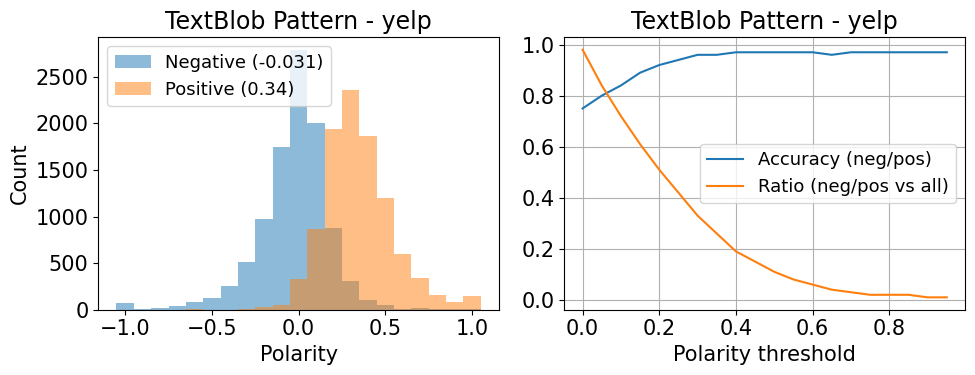

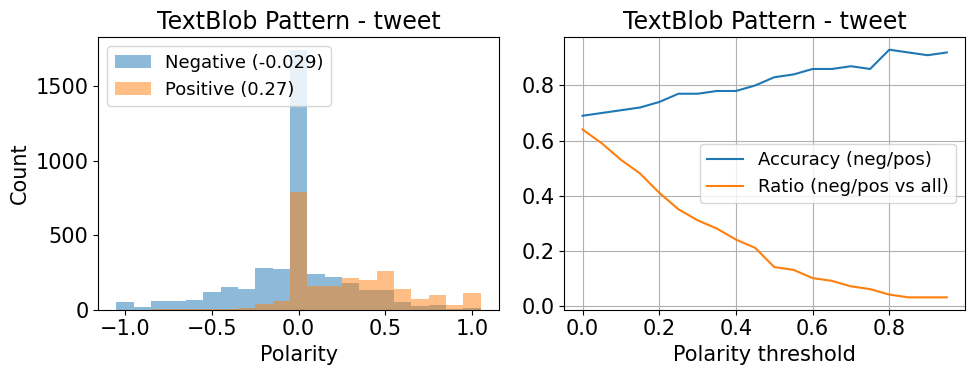

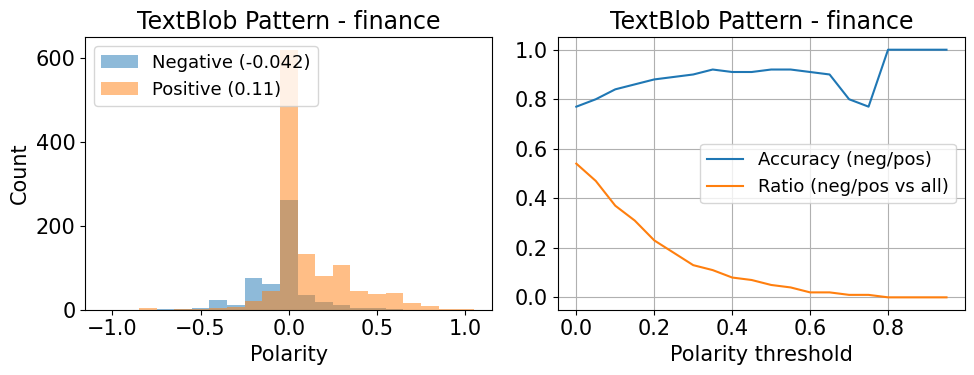

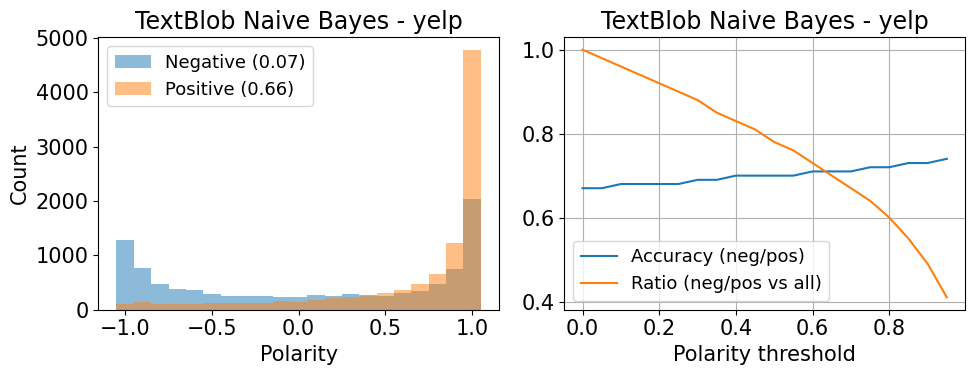

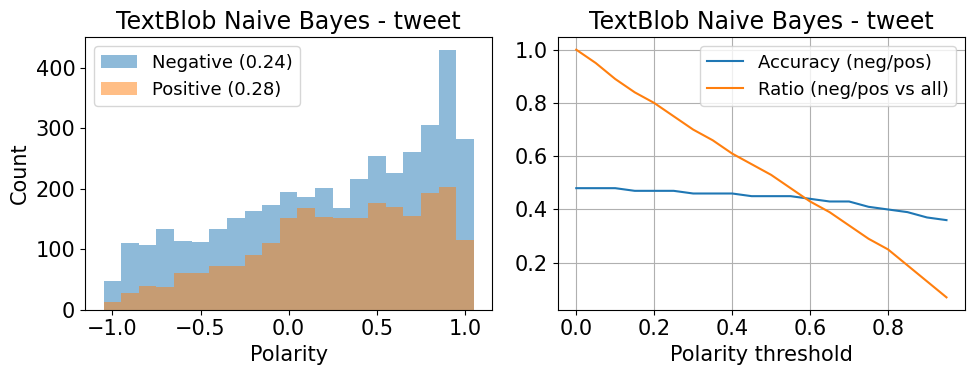

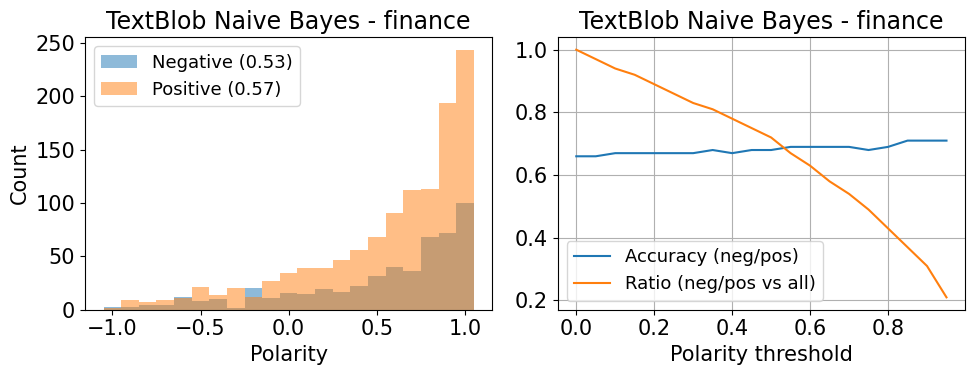

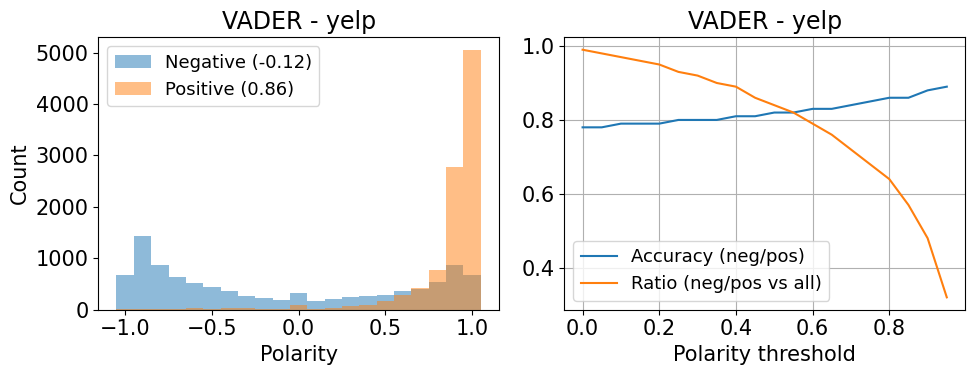

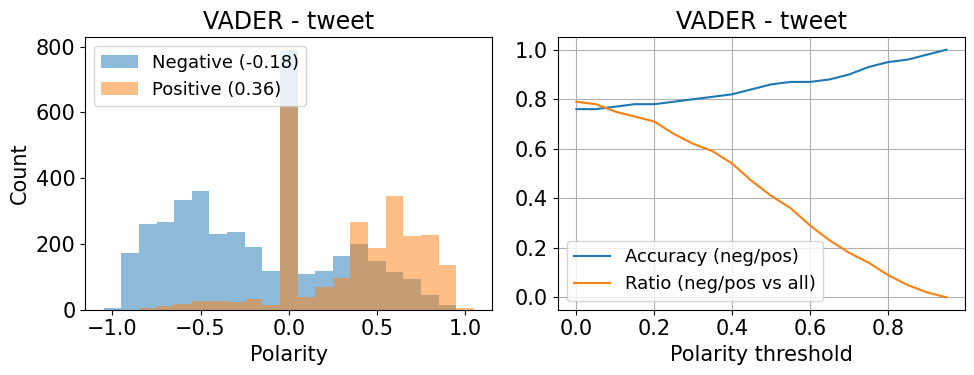

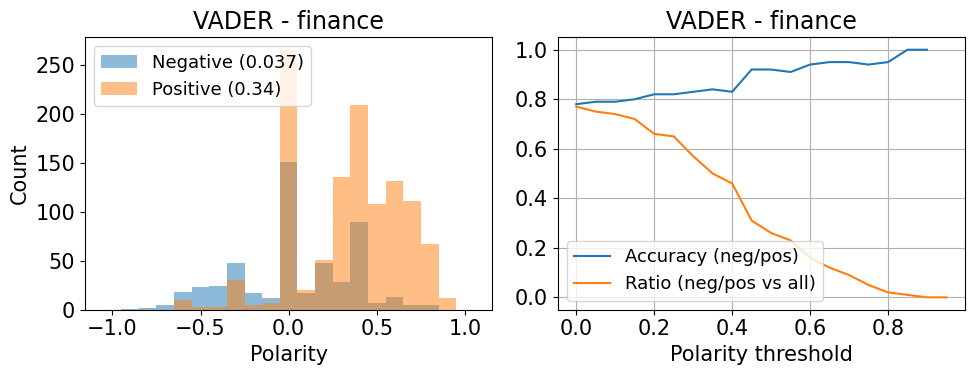

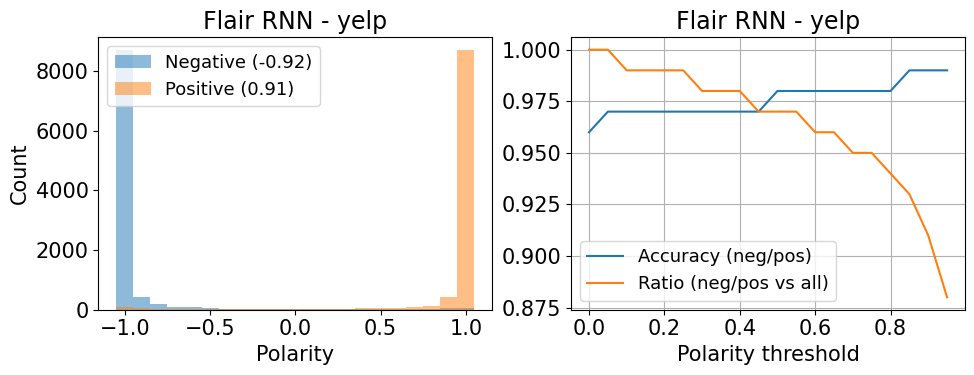

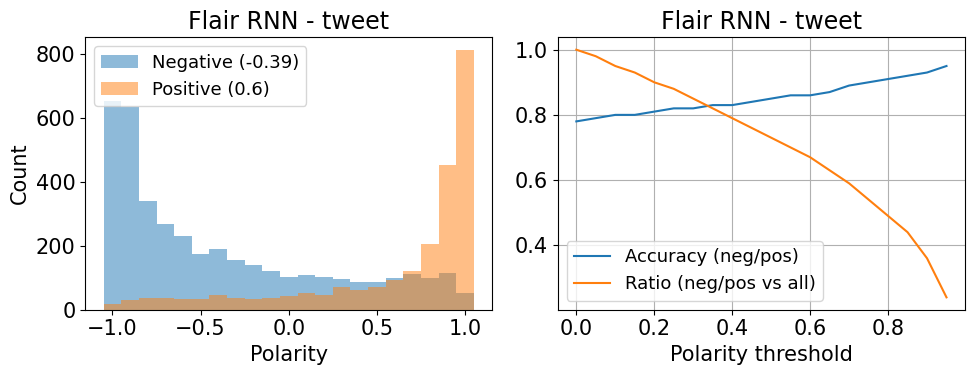

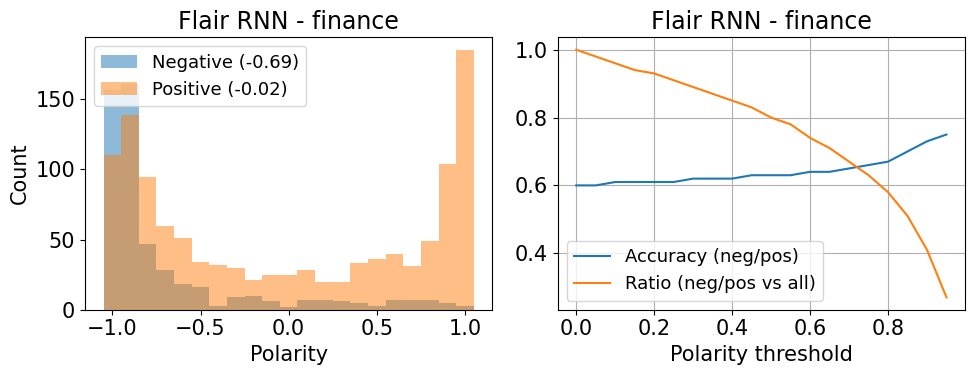

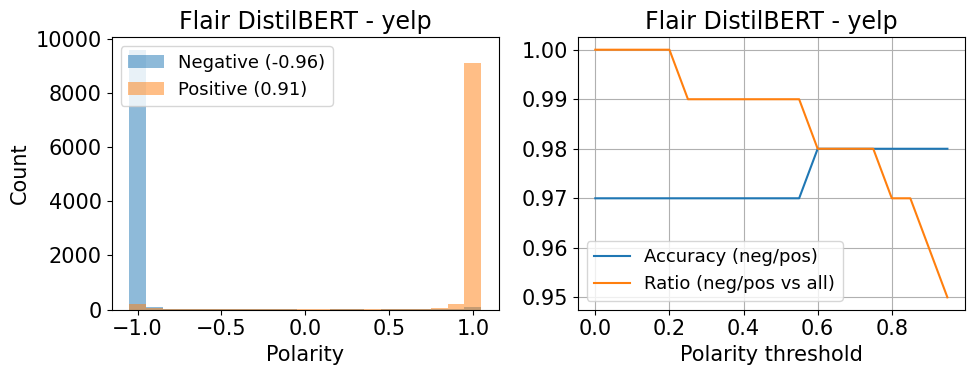

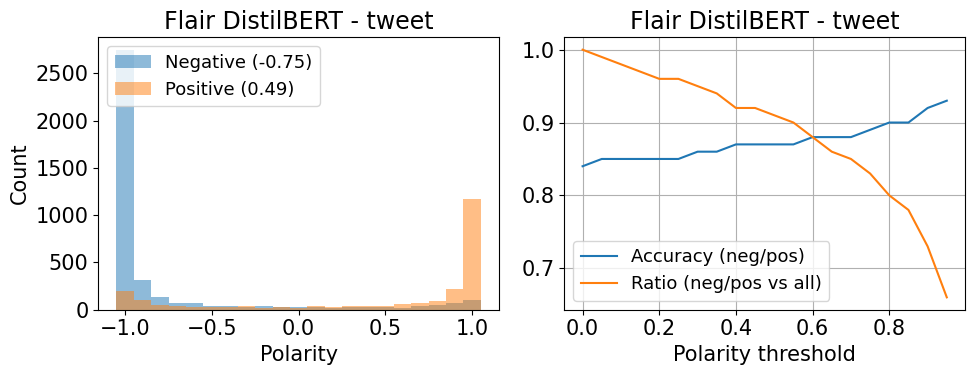

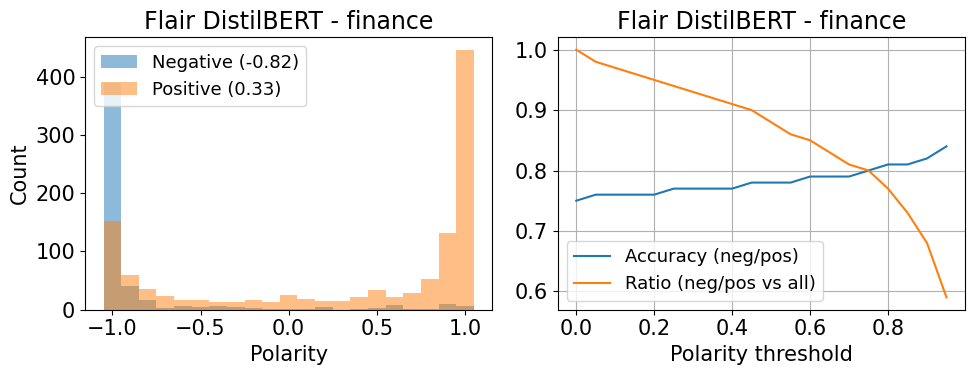

In [52]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
    'axes.titlesize': FONT_SIZE + 2,
    'axes.labelsize': FONT_SIZE,
    'xtick.labelsize': FONT_SIZE,
    'ytick.labelsize': FONT_SIZE,
    'legend.fontsize': FONT_SIZE - 2,
    'font.size': FONT_SIZE,
})
np.seterr(divide='ignore', invalid='ignore')

for model_name, title in model_title:
    for dataset in DATASETS:
        plot_all(model_name, title, dataset)

## Prediction definitions

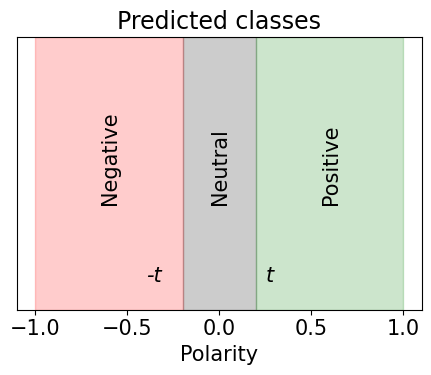

In [53]:
threshold = 0.2
height = 1
fig, ax = plt.subplots(1, 1, figsize=(9, 4))
ax.set_title('Predicted classes')
ax.set_xlabel('Polarity')
ax.set_xticks(np.arange(-1.0, 1.5, 0.5))
ax.set_yticks([])
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([0, height])
rect_neg = matplotlib.patches.Rectangle((-1, 0), (1 - threshold), height, color='red', alpha=0.2)
rect_neu = matplotlib.patches.Rectangle((-threshold, 0), 2 * threshold, height, color='black', alpha=0.2)
rect_pos = matplotlib.patches.Rectangle((threshold, 0), (1 - threshold), height, color='green', alpha=0.2)
ax.add_patch(rect_neg)
ax.add_patch(rect_neu)
ax.add_patch(rect_pos)
ax.text(-0.65, 0.4 * height, 'Negative', rotation=90)
ax.text(-0.05, 0.4 * height, 'Neutral', rotation=90)
ax.text(0.55, 0.4 * height, 'Positive', rotation=90)
ax.text(-threshold - 0.2, 0.1 * height, '-t', style='italic')
ax.text(threshold + 0.05, 0.1 * height, 't', style='italic')
plt.tight_layout(rect=(0.25, 0, 0.75, 1))
plt.savefig(f'{FIGURE_PATH}/classes_polarity.png')
plt.show()